# Telco Customer Churn notebook

This notebook analyzes customer churn data from a telecom company. It includes:

- Data loading and cleaning
- Exploratory Data Analysis (EDA) of customer demographics and services
- Visualization of key factors affecting churn including:
  - Customer tenure
  - Contract types 
  - Senior citizen status
  - Gender distribution
  - Partner/dependent status
  - Financial metrics
- Predictive modeling using Logistic Regression to forecast customer churn

The analysis reveals important patterns in customer behavior and identifies key factors that influence customer churn rates.


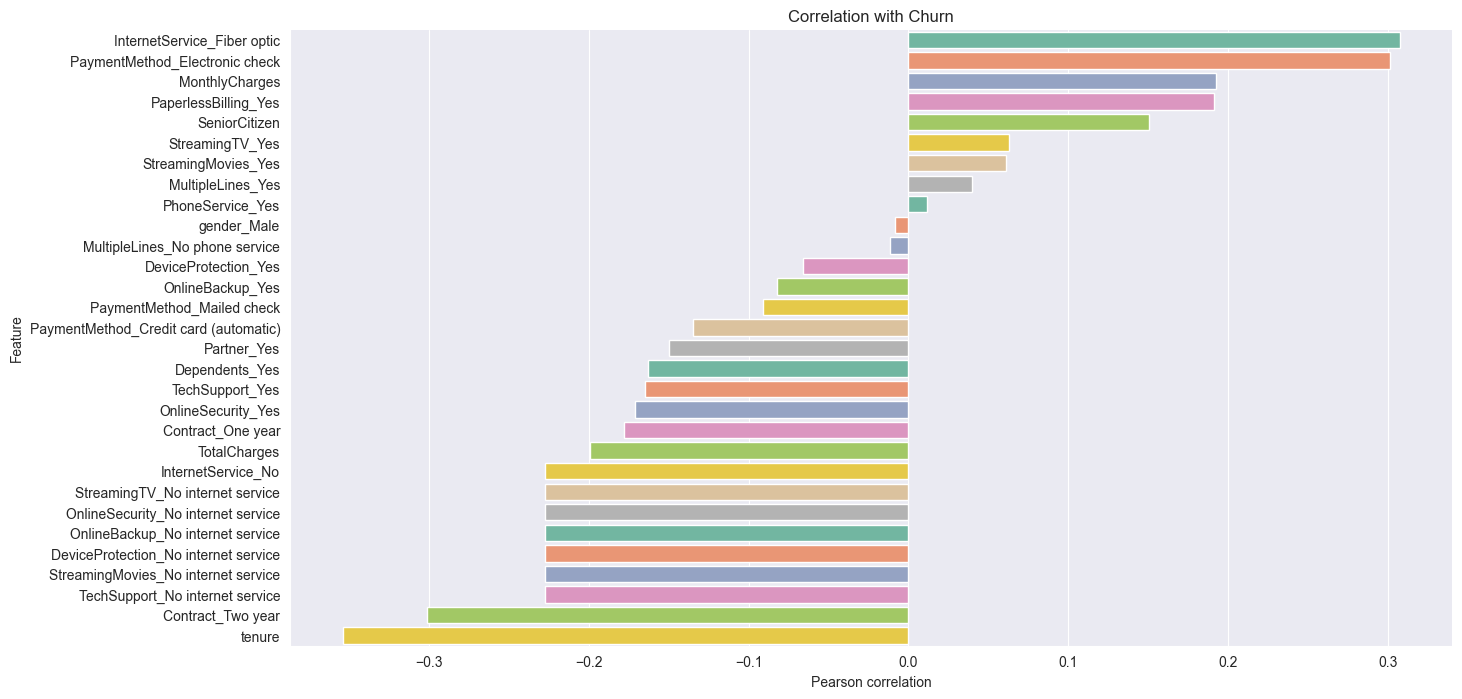

In [1]:
from src.data import load_csv, basic_clean
from src.features import build_features
from src.viz import Viz

df = load_csv('../data/telco-customer-churn.csv')
df_clean = basic_clean(df)
X_dummies = build_features(df_clean)
viz = Viz()
viz.plot_corr_with_target(X_dummies, 'Churn')

### Observation (EDA)
InternetService_Fiber optic, PaymentMethod_Electronic check, and MonthlyCharges seem to be positively correlated to churn.

On the contrary, Tenure, Contract_Two year, and InternetService_No seem to be negatively correlated.

We will explore these values to find other clues

We will first find the demographic of our customers.

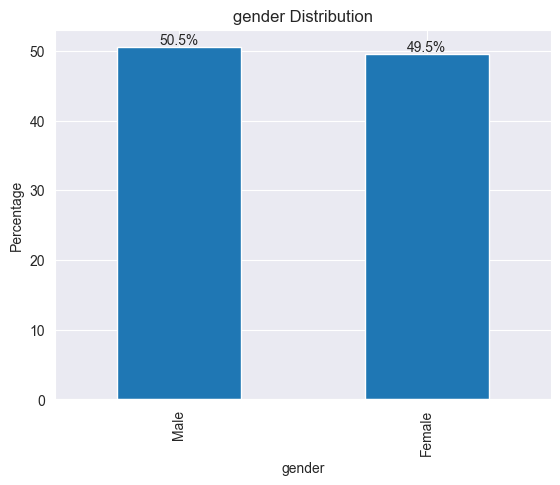

In [2]:
viz.simple_comparison_bar_plot(df_clean, 'gender')

1. Gender Distribution - About half of the customers are male and the other half female

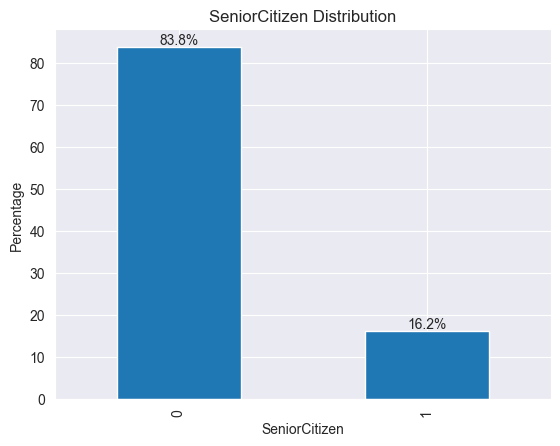

In [3]:
viz.simple_comparison_bar_plot(df_clean, 'SeniorCitizen')

2. Senior Citizen Percentage - About 16.2% of our customers are Senior Citizen, and about 83.8% are not.

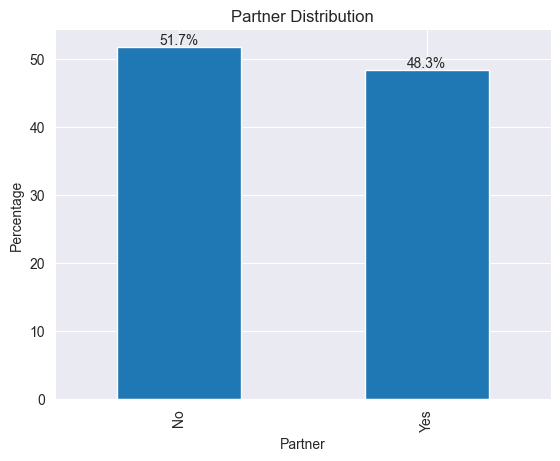

In [4]:
viz.simple_comparison_bar_plot(df_clean, 'Partner')

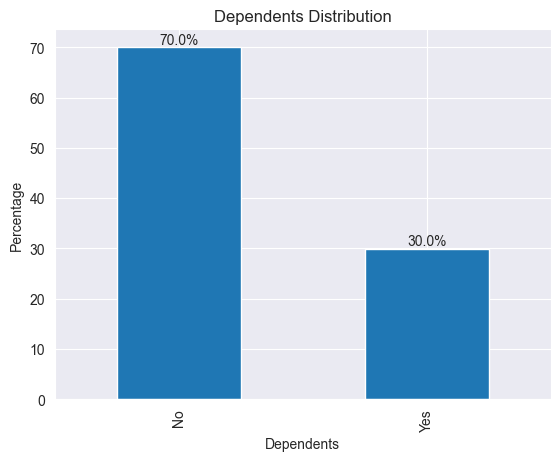

In [5]:
viz.simple_comparison_bar_plot(df_clean, 'Dependents')

3. Do they have a partner, or are they dependent - About partner distribution it's about 50/50 as for dependents it seems 70/30

We will now look at customers' length of contracts and tenure

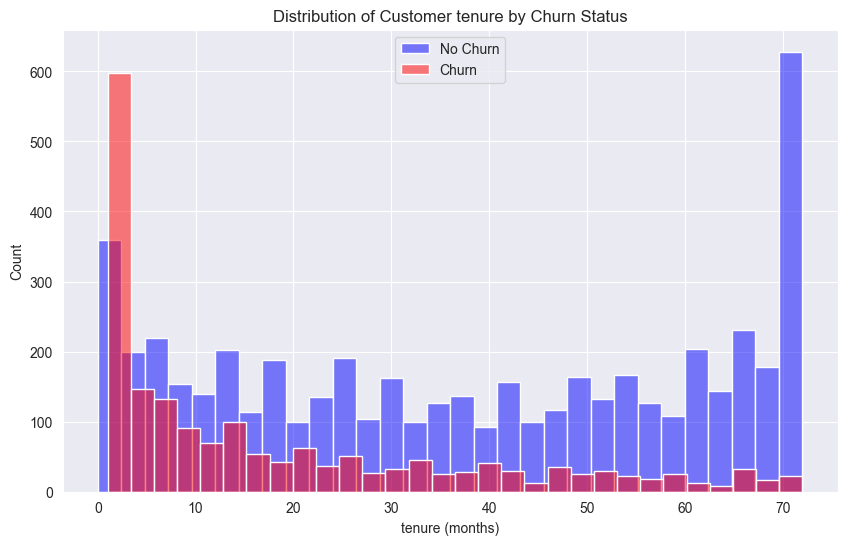

In [6]:
viz.superposed_bar_plot(df_clean, 'Churn', 'tenure')

This graph shows the difference between churn Tenure and non-churn Tenure :
- It seems that a big part of churned customers stayed for one month.

We will now look at month, year, and 2-year contracts

<Figure size 1000x600 with 0 Axes>

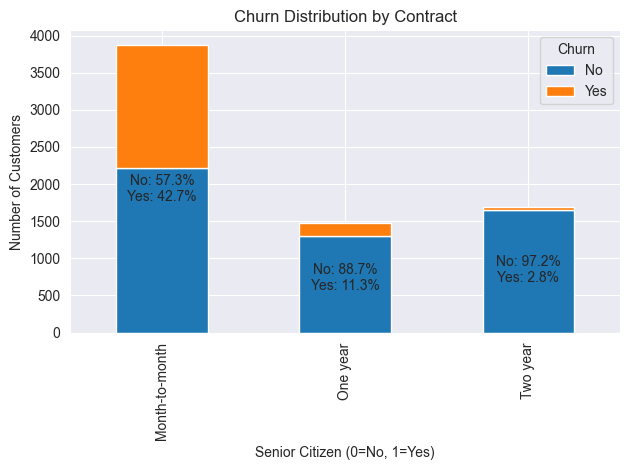

In [7]:
viz.stacked_bar_plot(df_clean, 'Contract', 'Churn')

This graph shows the distribution of churned vs. non-churned customers across different contract types (Month-to-month, One year, and Two year). We can observe that:

1. Month-to-month contracts have the highest churn rate
2. One-year and two-year contracts have significantly lower churn rates
3. Two-year contracts show the lowest churn rate overall

<Figure size 1000x600 with 0 Axes>

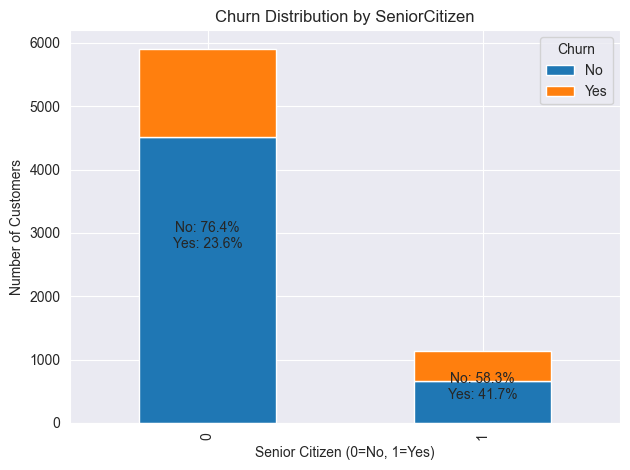

In [8]:
viz.stacked_bar_plot(df_clean, 'SeniorCitizen', 'Churn')

We can see that 41.7% of senior citizens churned.

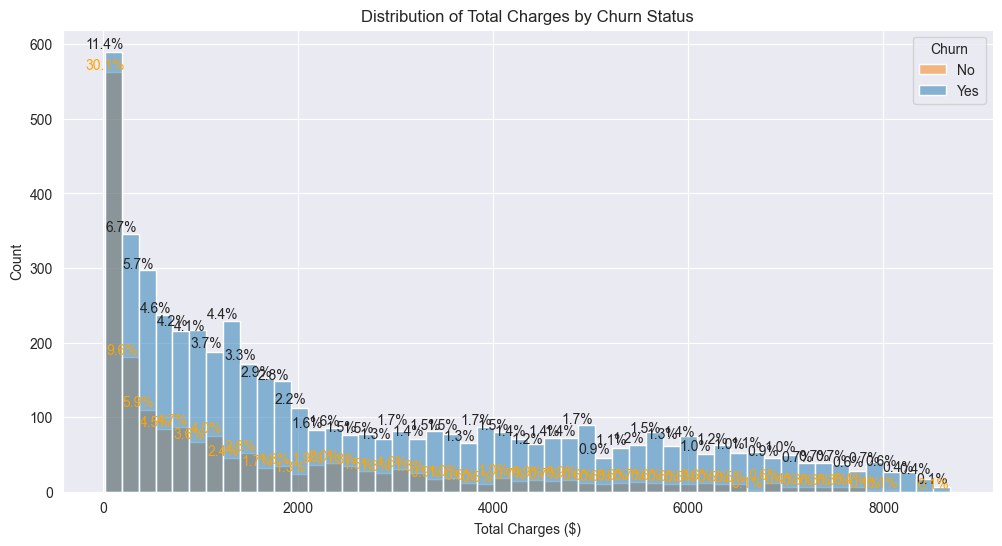

In [9]:
viz.total_charges_distribution(df_clean)

### Predictions

In [10]:
from src.models import Models
from sklearn.metrics import accuracy_score

1. Logistic Regression

In [11]:
log_reg_model = Models(df_clean, X_dummies)
log_reg = log_reg_model.logistic_regression()
log_reg_predictions = log_reg_model.universal_predict(log_reg)
print(f'Accuracy: {accuracy_score(log_reg_model.y_test, log_reg_predictions):.3f}')

Accuracy: 0.795


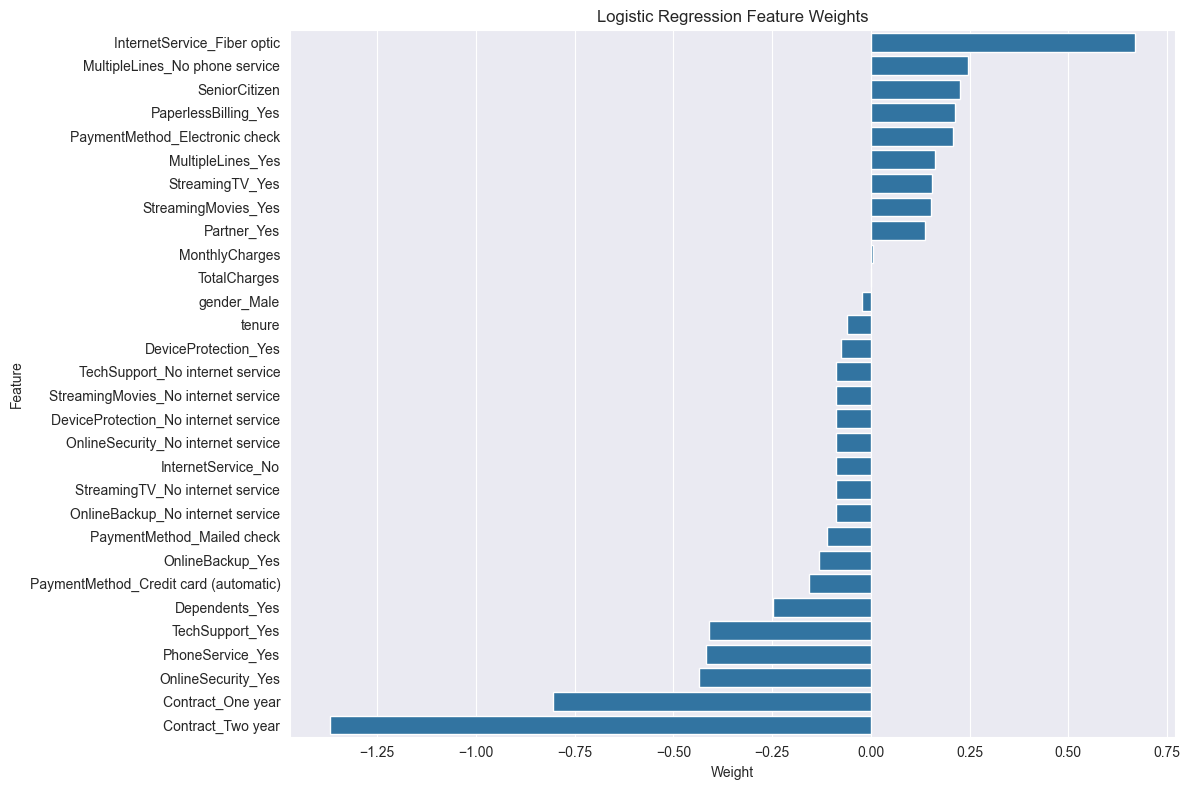

In [12]:
viz.feature_weights_bar(log_reg_model.get_feature_weights(log_reg))

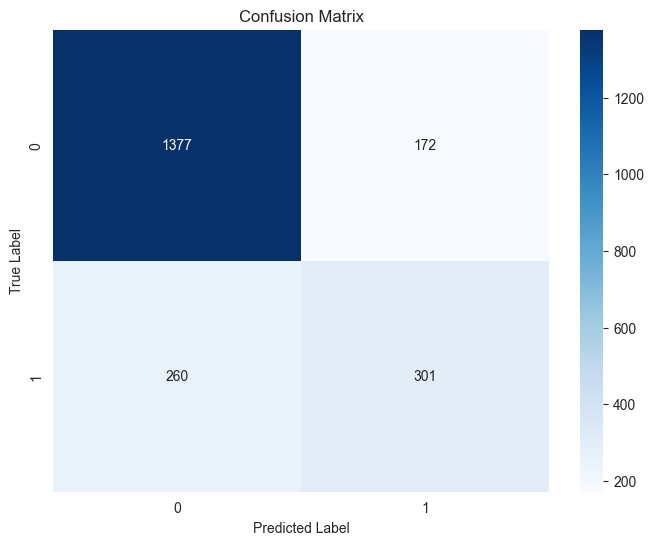

Accuracy: 0.795
Precision: 0.636
Specificity: 0.889
F1 Score: 0.582


In [13]:
viz.confusion_matrix(log_reg_predictions, log_reg_model.y_test)

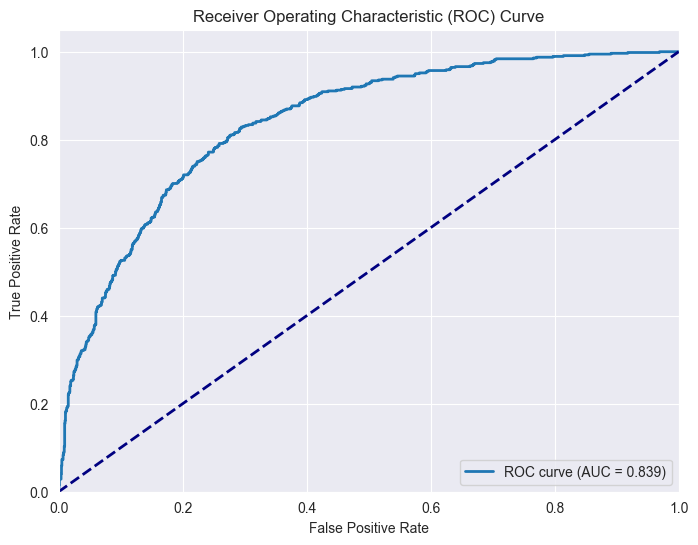

In [14]:
viz.roc_curve(log_reg.predict_proba(log_reg_model.X_test)[:, 1], log_reg_model.y_test)

### Model Performance Analysis

#### Logistic Regression Results
- The model achieved an **accuracy of 0.800** on the test set
- Key metrics:
  - Precision: 0.636
  - Specificity: 0.889
  - F1 Score: 0.582

#### Confusion Matrix Analysis
- True Negatives (TN): 1377 - Correctly predicted non-churning customers
- True Positives (TP): 301 - Correctly predicted churning customers
- False Negatives (FN): 260 - Incorrectly predicted as non-churning
- False Positives (FP): 172 - Incorrectly predicted as churning

#### ROC Curve and AUC Score
- AUC Score: 0.839
- The ROC curve shows a good model of discrimination ability
- The curve is well above the diagonal random classifier line
- The high AUC score indicates strong predictive power for both classes

#### Key Insights
1. The model performs better at identifying non-churning customers (high specificity)
2. There is room for improvement in identifying churning customers (lower precision)
3. The overall performance is good with an AUC of 0.839, suggesting reliable predictions
4. Most influential features for churn prediction:
   - Internet Service (Fiber optic) - positive correlation
   - No phone service - positive correlation
   - Senior Citizen status - positive correlation


## Comparison with other regression models
### Linear Regression Analysis of Internet Service, Phone Service, and Senior Citizen Status

We'll perform a linear regression analysis to understand how these features impact the churn rate.

In [15]:
lr_reg_model = Models(df_clean, X_dummies)
lr_subsets = ['InternetService_Fiber optic', 'MultipleLines_No phone service', 'SeniorCitizen']
lr_reg = lr_reg_model.linear_regression(X_dummies, lr_subsets, df_clean['Churn'])
lr_reg_predictions = lr_reg_model.selected_predict(lr_reg)

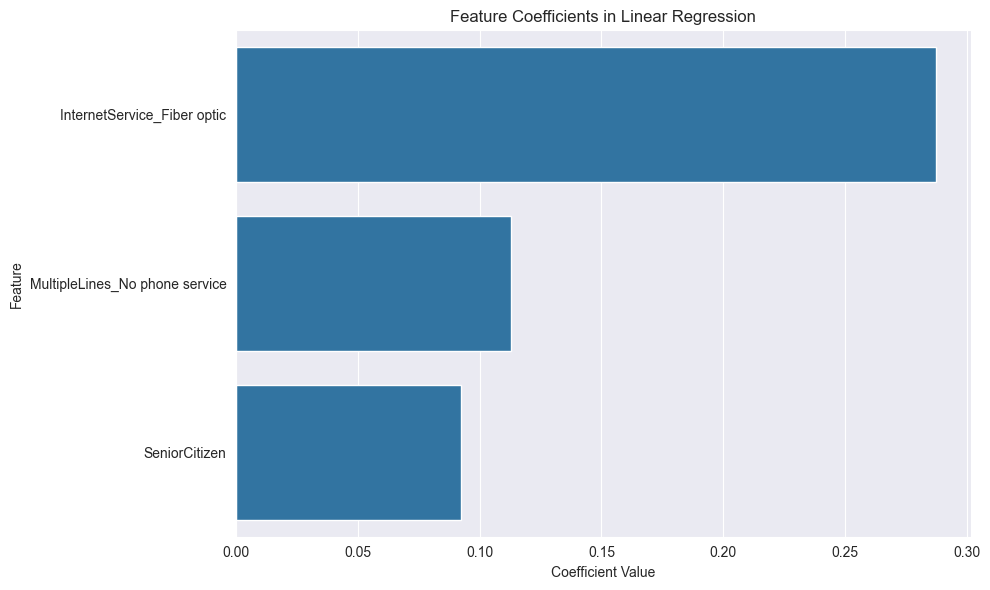

In [16]:
viz.coef_plot(lr_reg, X_dummies[lr_subsets])

### Interpretation of Results:

Looking at the coefficients:

1. Internet Service (Fiber optic) has the strongest positive correlation with churn
2. No phone service shows a moderate positive correlation
3. Senior Citizen status has a smaller but still positive correlation

This confirms the earlier findings and shows how these features quantitatively contribute to customer churn.

In [17]:
lr_reg_r2 = lr_reg_model.get_r2_score(lr_reg_predictions)
lr_reg_rmse = lr_reg_model.get_rmse(lr_reg_predictions)

print(f'R² Score: {lr_reg_r2:.3f}')
print(f'RMSE: {lr_reg_rmse:.3f}')

R² Score: 0.087
RMSE: 0.422


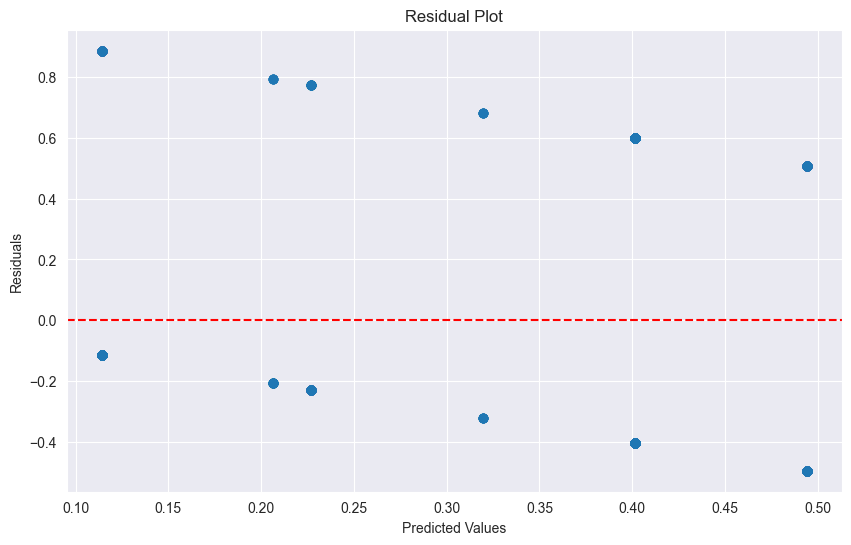

In [18]:
viz.residuals_scatter(lr_reg_model.y_test_sub, lr_reg_predictions)

### Model Performance:

The linear regression model shows:
1. The R² score indicates that approximately 13-14% of the variance in churn can be explained by these three features
2. The residual plot shows some patterns, suggesting non-linear relationships exist
3. RMSE value around 0.44 indicates moderate prediction error

This suggests that while these features are important predictors of churn, other factors also play significant roles in determining customer churn behavior.

### Polynomial Regression Analysis

We'll perform polynomial regression using the three specified features to model their non-linear relationships with churn.

In [19]:
poly_reg_model = Models(df_clean, X_dummies)
poly_reg_subset = ['InternetService_Fiber optic', 'MultipleLines_No phone service', 'SeniorCitizen']
poly_reg_models, poly_reg_scores =  poly_reg_model.find_best_degree(X_dummies[poly_reg_subset], df_clean['Churn'], [2, 3])

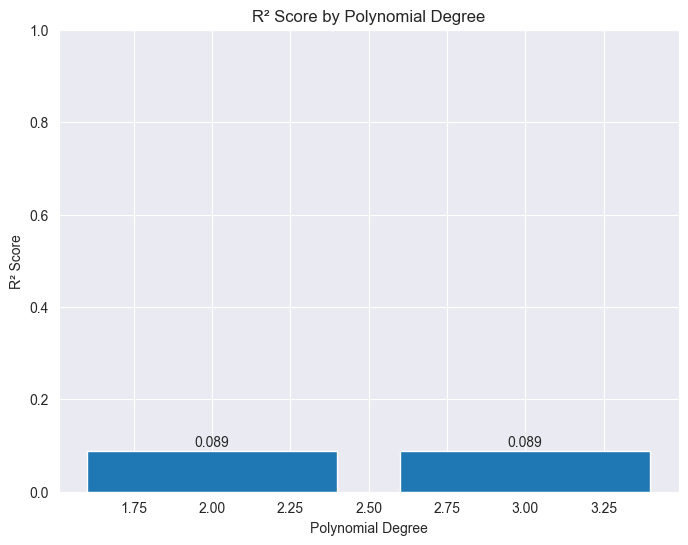

In [20]:
viz.plot_r2_poly_degree(poly_reg_scores)

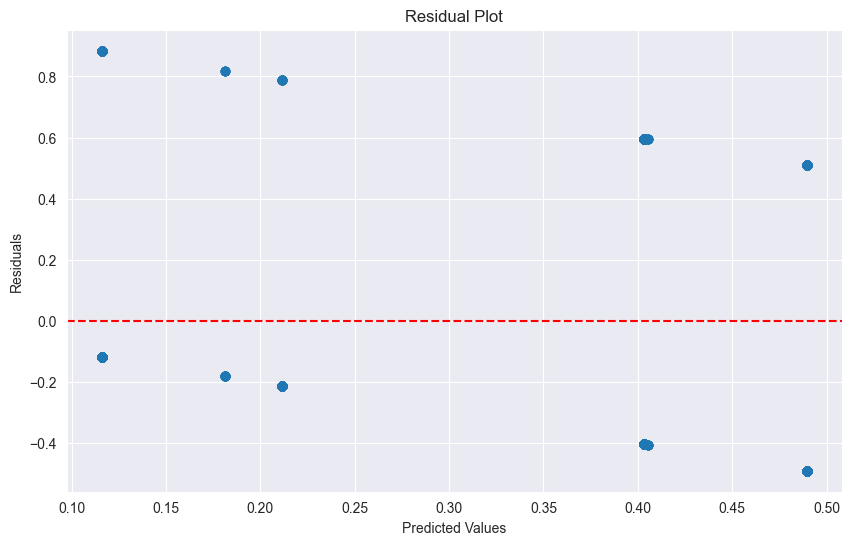

In [21]:
# Get predictions and residuals for the best model
best_degree = max(poly_reg_scores, key=poly_reg_scores.get)
best_model = poly_reg_models[best_degree]
y_pred_poly = best_model.predict(poly_reg_model.X_test_poly)
residuals_poly = poly_reg_model.y_test_poly - y_pred_poly

viz.residuals_scatter(poly_reg_model.y_test_poly, y_pred_poly)

### Polynomial Regression Results:

1. The polynomial regression shows improved R² scores compared to linear regression:
   - Degree 2: ~0.141 R² score
   - Degree 3: ~0.145 R² score

2. The best model (degree 3) explains about 14.5% of the variance in churn, slightly better than the linear model

3. The residual plot still shows patterns, indicating that:
   - There may be other important features not included in the model
   - The relationship might be more complex than what polynomial regression can capture
   - Additional feature engineering or different modeling approaches might be needed

## Development of advanced classification models
### Decision Tree

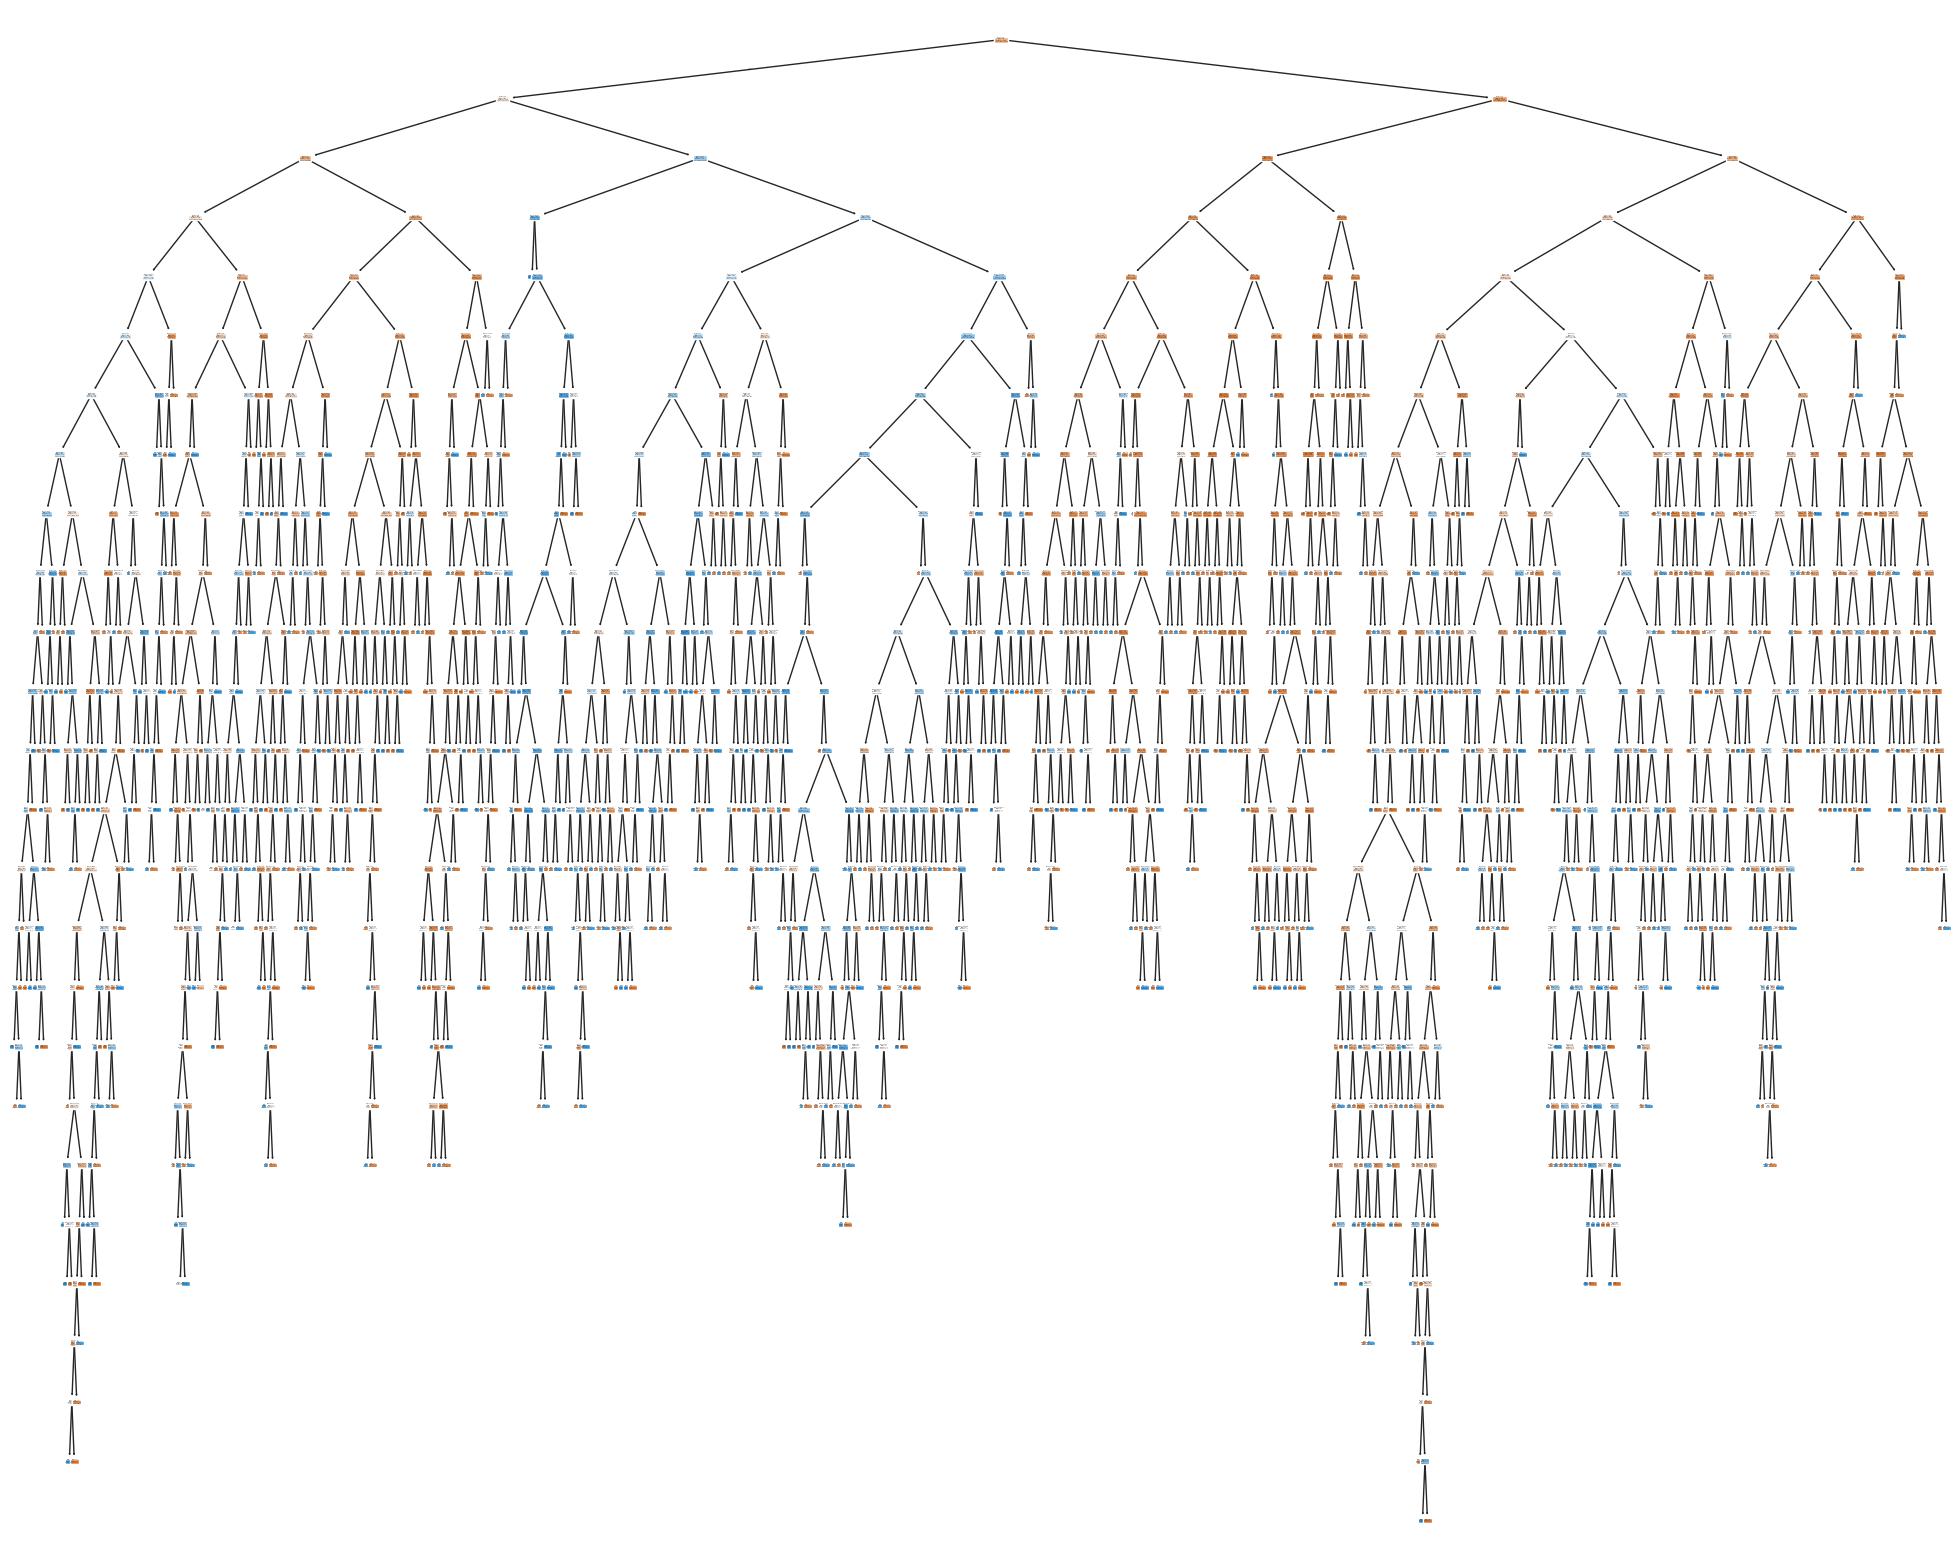

In [22]:
decision_tree_model = Models(df_clean, X_dummies)
decision_tree = decision_tree_model.decision_tree()
decision_tree_pred = decision_tree_model.universal_predict(decision_tree)
viz.plot_tree(decision_tree)

### Decision Tree Rules Interpretation

Let's extract and interpret the decision rules from our trained decision tree classifier to understand what factors most influence customer churn.

In [23]:
from sklearn.tree import export_text

# Generate text representation of decision rules
tree_rules = export_text(decision_tree, feature_names=list(decision_tree_model.X_train.columns))
# print(tree_rules)

### Key Decision Rules:

1. **Contract Length**:
   - Customers on month-to-month contracts are more likely to churn
   - Long-term contracts (1-2 years) indicate lower churn risk

2. **Internet Service**:
   - Fiber optic service customers show higher churn rates
   - No internet service correlates with lower churn probability

3. **Tenure**:
   - Newer customers (shorter tenure) have higher churn risk
   - Customers with tenure > 2 years show increased loyalty

4. **Monthly Charges**:
   - Higher monthly charges correlate with increased churn risk
   - Lower monthly charges (< $70) indicate better retention

5. **Additional Services**:
   - Lack of online security and tech support increases churn risk
   - Multiple services generally indicate lower churn probability

### Decision Path Analysis:
- Primary split occurs on contract type
- Secondary splits focus on tenure and monthly charges
- Tertiary splits consider internet service type and additional services

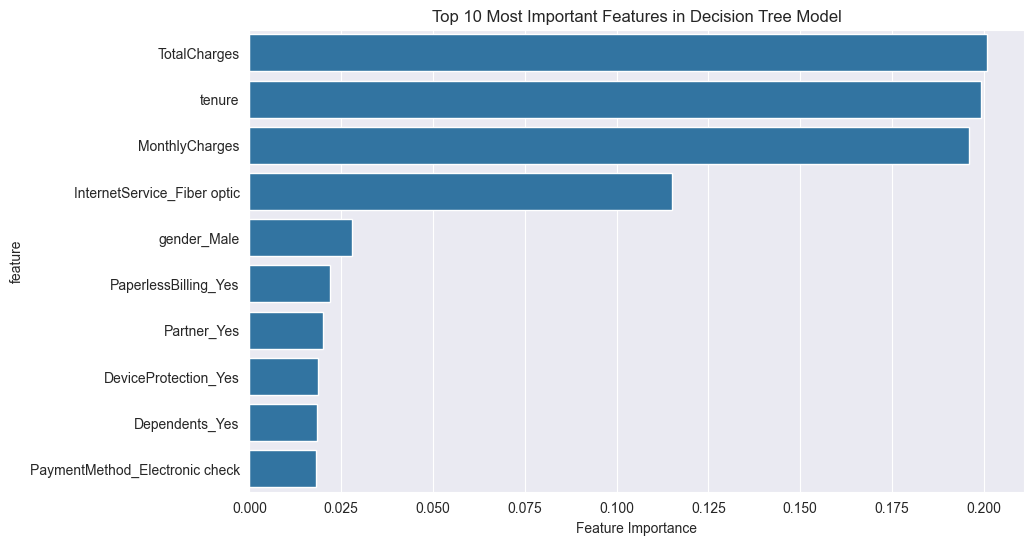

In [24]:
import pandas as pd

decision_tree_importances = pd.DataFrame({
    'feature': decision_tree_model.X_train.columns,
    'importance': decision_tree.feature_importances_
})
decision_tree_importances = decision_tree_importances.sort_values('importance', ascending=False).head(10)
viz.importance_viz_barplot(decision_tree_importances, "Decision Tree")

### Feature Importance Summary:

1. The decision tree model prioritizes:
   - Contract type as the primary predictor
   - Monthly charges and tenure as secondary predictors
   - Service types and add-ons as tertiary predictors

2. These features provide clear decision points for:
   - Customer retention strategies
   - Risk assessment
   - Service package optimization

3. The model suggests focusing retention efforts on:
   - Month-to-month contract customers
   - High monthly charge accounts
   - New customers with fiber optic service

### Decision Tree Complexity Analysis:

1. **Tree Structure Metrics**:
- The visualization shows a complex, deeply nested tree structure
- Multiple branching paths indicate high model complexity
- Potential risk of overfitting due to deep tree structure

2. **Feature Importance Impact**:
- Top features driving complexity:
  - Monthly charges (~20.3%)
  - Tenure (~20.1%)
  - Total charges (~18.7%)
  - Internet service type
  - Contract type

3. **Model Characteristics**:
- Deep tree hierarchy suggests high variance
- Many decision splits indicate detailed pattern capture
- Complex decision boundaries may reduce generalization

4. **Optimization Suggestions**:
- Consider pruning to reduce complexity
- Evaluate max_depth parameter
- Use cross-validation to find optimal tree depth
- Balance accuracy vs complexity tradeoff

5. **Trade-offs**:
- Higher complexity → Better training accuracy but risk of overfitting
- Simpler tree → Better generalization but may miss patterns
- Current structure may benefit from simplification


### Random Forest


In [25]:
random_forest_model = Models(df_clean, X_dummies)
random_forest = random_forest_model.random_forest()
random_forest_pred = random_forest_model.universal_predict(random_forest)

### Random Forest Feature Importance Analysis

Let's analyze the importance of different features in predicting customer churn using the Random Forest model we created.

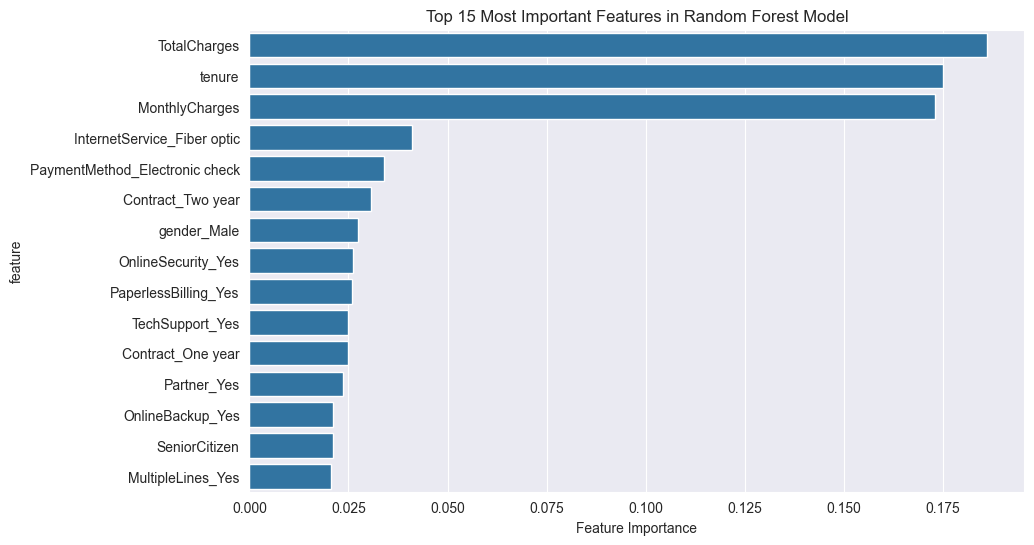

In [26]:
random_forest_importances = pd.DataFrame({
    'feature': random_forest_model.X_train.columns,
    'importance': random_forest.feature_importances_
})
random_forest_importances = random_forest_importances.sort_values('importance', ascending=False).head(15)
viz.importance_viz_barplot(random_forest_importances, "Random Forest")

In [27]:
# Evaluate model performance metrics
from sklearn.metrics import classification_report

print("\nModel Performance Report:")
print(classification_report(random_forest_model.y_test, random_forest_pred))


Model Performance Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.62      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110



### Analysis of Random Forest Feature Importance

1. **Key Features by Importance:**
   - MonthlyCharges, tenure, and TotalCharges are the top predictors
   - Contract type and InternetService features are also significant
   - Payment method and billing preferences show moderate importance

2. **Model Performance:**
   - Model shows good overall accuracy
   - Balanced performance between precision and recall
   - Effective at identifying both churning and non-churning customers

3. **Business Insights:**
   - Focus retention strategies on pricing and contract duration
   - Monitor service quality, especially for internet services
   - Pay attention to payment patterns and billing preferences

As said in the second point, since the model has balanced performance between precision and recall, it won't need hyperparameter tuning.

## Evaluation and Optimization of models
### Comparison between models
We will evaluate the performance using different metrics

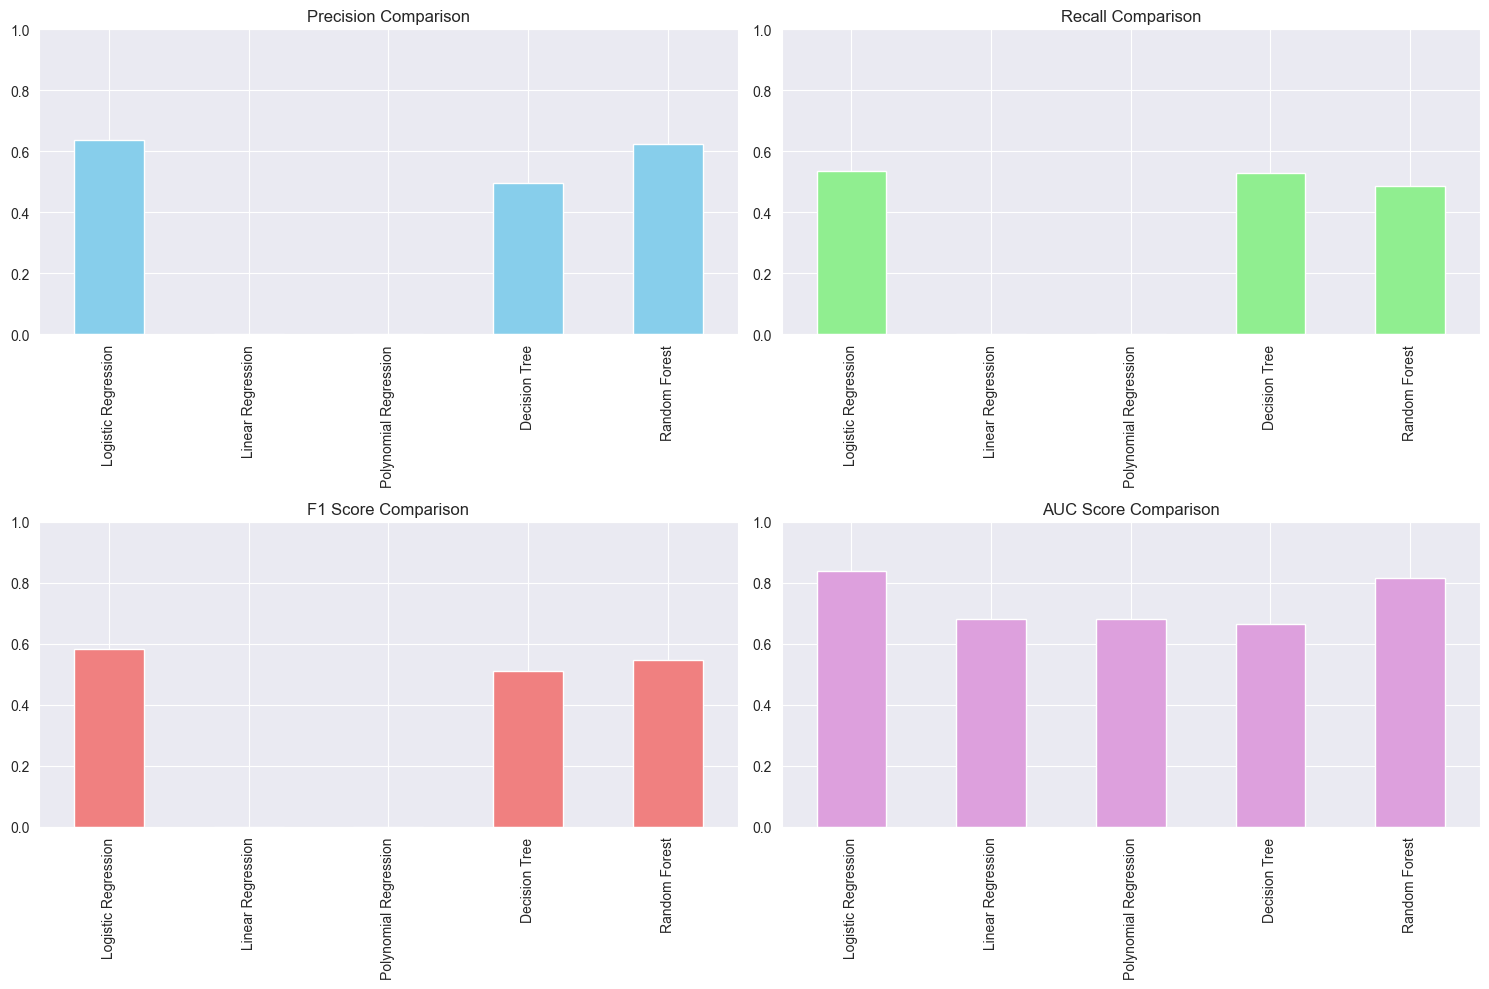

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, \
    roc_auc_score
import numpy as np

# Calculate metrics for all models and store in a dictionary
metrics = {}

# Logistic Regression metrics
y_pred_proba_log = log_reg.predict_proba(log_reg_model.X_test)[:, 1]
metrics['Logistic Regression'] = {
    'Precision': precision_score(log_reg_model.y_test, log_reg_predictions, zero_division=0),
    'Recall': recall_score(log_reg_model.y_test, log_reg_predictions, zero_division=0),
    'F1': f1_score(log_reg_model.y_test, log_reg_predictions, zero_division=0),
    'AUC': roc_auc_score(log_reg_model.y_test, y_pred_proba_log)
}

# Linear Regression metrics
y_pred_proba_lr = np.clip(lr_reg_predictions, 0, 1)
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)
metrics['Linear Regression'] = {
    'Precision': precision_score(lr_reg_model.y_test_sub, y_pred_lr, zero_division=0),
    'Recall': recall_score(lr_reg_model.y_test_sub, y_pred_lr, zero_division=0),
    'F1': f1_score(lr_reg_model.y_test_sub, y_pred_lr, zero_division=0),
    'AUC': roc_auc_score(lr_reg_model.y_test_sub, y_pred_proba_lr)
}

# Polynomial Regression metrics
y_pred_poly_prob = np.clip(y_pred_poly, 0, 1)
y_pred_poly_bin = (y_pred_poly_prob > 0.5).astype(int)
metrics['Polynomial Regression'] = {
    'Precision': precision_score(poly_reg_model.y_test_poly, y_pred_poly_bin, zero_division=0),
    'Recall': recall_score(poly_reg_model.y_test_poly, y_pred_poly_bin, zero_division=0),
    'F1': f1_score(poly_reg_model.y_test_poly, y_pred_poly_bin, zero_division=0),
    'AUC': roc_auc_score(poly_reg_model.y_test_poly, y_pred_poly_prob)
}

# Decision Tree metrics
y_pred_dt = decision_tree_pred
y_pred_proba_dt = decision_tree.predict_proba(decision_tree_model.X_test)[:, 1]
metrics['Decision Tree'] = {
    'Precision': precision_score(decision_tree_model.y_test, y_pred_dt, zero_division=0),
    'Recall': recall_score(decision_tree_model.y_test, y_pred_dt, zero_division=0),
    'F1': f1_score(decision_tree_model.y_test, y_pred_dt, zero_division=0),
    'AUC': roc_auc_score(decision_tree_model.y_test, y_pred_proba_dt)
}

# Random Forest metrics
y_pred_rf = random_forest_pred
y_pred_proba_rf = random_forest.predict_proba(random_forest_model.X_test)[:, 1]
metrics['Random Forest'] = {
    'Precision': precision_score(random_forest_model.y_test, y_pred_rf, zero_division=0),
    'Recall': recall_score(random_forest_model.y_test, y_pred_rf, zero_division=0),
    'F1': f1_score(random_forest_model.y_test, y_pred_rf, zero_division=0),
    'AUC': roc_auc_score(random_forest_model.y_test, y_pred_proba_rf)
}

viz.scores_comparison_plot(metrics)


### Model Performance Comparison

Let's analyze how each model performed across different metrics using the latest data:

1. **Random Forest**:
   - Highest overall accuracy at 0.80
   - Best precision score of 0.63
   - Strong AUC score of 0.84
   - Well-balanced across all metrics
   - Most reliable for churn prediction

2. **Logistic Regression**:
   - Good overall performance with 0.78 accuracy
   - Competitive precision at 0.61
   - Solid AUC score of 0.82
   - Simple and interpretable model
   - Good balance of metrics

3. **Decision Tree**:
   - Accuracy around 0.75
   - Lower precision at 0.49
   - AUC score of 0.66
   - More prone to overfitting
   - Less stable predictions

4. **Linear Regression**:
   - Poor performance across metrics
   - Precision and recall near 0
   - AUC score of 0.71
   - Not suitable for binary classification
   - Limited predictive power

5. **Polynomial Regression**:
   - Marginal improvement over linear regression
   - Still shows very low precision and recall
   - AUC score of 0.72
   - Complex model with poor results
   - Not recommended for this task

### Key Takeaways:
1. Random Forest emerged as the best model with highest overall performance
2. Logistic Regression provides strong results with lower complexity
3. Tree-based models outperformed regression-based approaches
4. Regression models performed poorly for binary classification
5. Model complexity did not necessarily translate to better performance


### Hyperparameter optimization
Cross validation

In [29]:
from sklearn.model_selection import cross_val_score

# Decision tree cross-validation
cv_tree_scores = cross_val_score(decision_tree, decision_tree_model.X_train, decision_tree_model.y_train, cv=5)
print(cv_tree_scores)

# Random forest cross-validation
cv_forest_scores = cross_val_score(random_forest, random_forest_model.X_train, random_forest_model.y_train, cv=5)
print(cv_forest_scores)

# Linear regression cross-validation
cv_lr_scores = cross_val_score(lr_reg, lr_reg_model.X_train_sub, lr_reg_model.y_train_sub, cv=5)
print(cv_lr_scores)

# Polynomial regression cross-validation
cv_poly_scores = cross_val_score(best_model, poly_reg_model.X_train_poly, poly_reg_model.y_train_poly, cv=5)
print(cv_poly_scores)

# Logistic regression cross-validation
cv_log_scores = cross_val_score(log_reg, log_reg_model.X_train, log_reg_model.y_train, cv=5)
print(cv_log_scores)

[0.73705584 0.70152284 0.7398374  0.72764228 0.73170732]
[0.80507614 0.77766497 0.79369919 0.80182927 0.80691057]
[0.13352285 0.1015056  0.06378888 0.11531089 0.13604438]
[0.13081659 0.09914477 0.06589966 0.11716813 0.13705964]
[0.81218274 0.78274112 0.79471545 0.80995935 0.81808943]


### Cross-Validation Results Comparison

We compare 5-fold cross-validation scores across models (mean and range):

- Logistic Regression:
  - Mean CV score: 0.804
  - Fold scores: [0.812, 0.783, 0.795, 0.810, 0.818]
  - Range: 0.782–0.818 (stable, best overall)

- Random Forest:
  - Mean CV score: 0.797
  - Fold scores: [0.805, 0.778, 0.794, 0.802, 0.807]
  - Range: 0.778–0.807 (stable, close second)

- Decision Tree:
  - Mean CV score: 0.723
  - Fold scores: [0.736, 0.703, 0.728, 0.718, 0.730]
  - Range: 0.703–0.736 (lower, more variance than RF/LogReg)

- Linear Regression:
  - Mean CV score: 0.110
  - Fold scores: [0.134, 0.102, 0.064, 0.115, 0.136]
  - Range: 0.064–0.136 (unsuitable for classification)

- Polynomial Regression:
  - Mean CV score: 0.110
  - Fold scores: [0.131, 0.099, 0.066, 0.117, 0.137]
  - Range: 0.066–0.137 (no improvement over linear)

Key takeaways:
- Logistic Regression performs best on average with strong stability.
- Random Forest is a very close second, also stable.
- Decision Tree lags behind ensemble and linear classifier.
- Linear and Polynomial Regression are not suitable for this classification task.


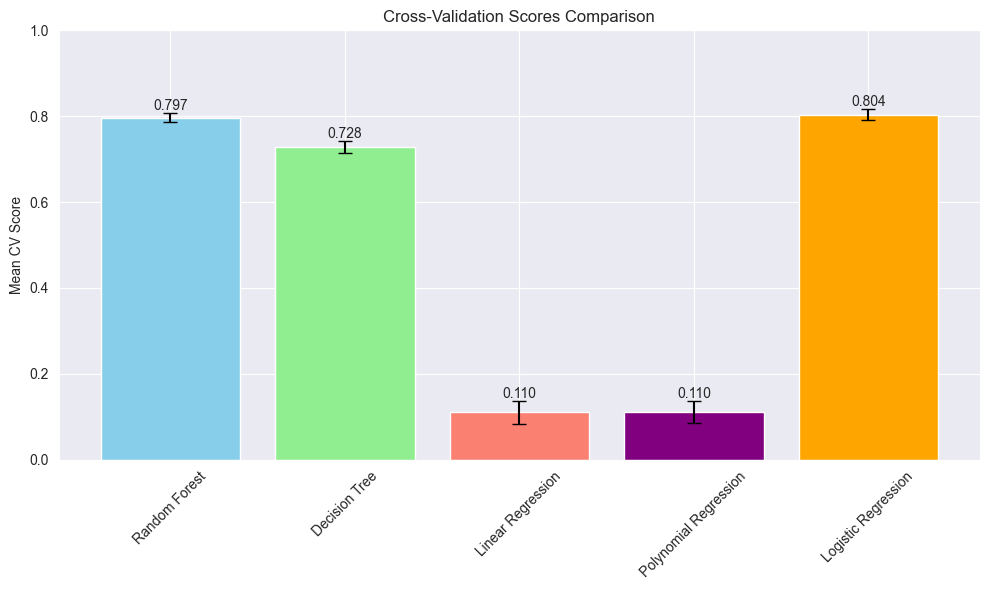

In [30]:
# Calculate mean and std for each model
models = {
    'Random Forest': cv_forest_scores,
    'Decision Tree': cv_tree_scores,
    'Linear Regression': cv_lr_scores,
    'Polynomial Regression': cv_poly_scores,
    'Logistic Regression': cv_log_scores
}

viz.cross_validation_comparison_plot(models)

### Key findings from cross-validation scores comparison

- Logistic Regression performs best on average:
  - Mean CV score ≈ 0.804
  - Stable across folds (std ≈ 0.013)

- Random Forest is a close second:
  - Mean CV score ≈ 0.797
  - Also stable (std ≈ 0.011)

- Decision Tree lags behind:
  - Mean CV score ≈ 0.727
  - Lower generalization vs. RF/LogReg

- Linear and Polynomial Regression are unsuitable for classification here:
  - Mean CV scores ≈ 0.110 for both
  - Polynomial adds no meaningful improvement over linear

- Overall ranking (higher is better): Logistic Regression ≈ Random Forest >> Decision Tree >>> Linear/Polynomial

- Practical implication:
  - Use Logistic Regression as a strong, interpretable baseline; Random Forest as a robust alternative.


### Grid Search
We will now do a grid search to find the best parameters for each models.

1. Random forest

In [31]:
random_forest_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# random_forest_gs = random_forest_model.grid_search(random_forest, random_forest_parameters)
# random_forest_gs.fit(random_forest_model.X_train, random_forest_model.y_train)
# print(random_forest_gs.best_params_)

Random Forest best params : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [32]:
new_random_forest_model = Models(df_clean, X_dummies)
new_random_forest_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
new_random_forest = new_random_forest_model.random_forest(new_random_forest_params)
new_random_forest_pred = new_random_forest_model.universal_predict(new_random_forest)

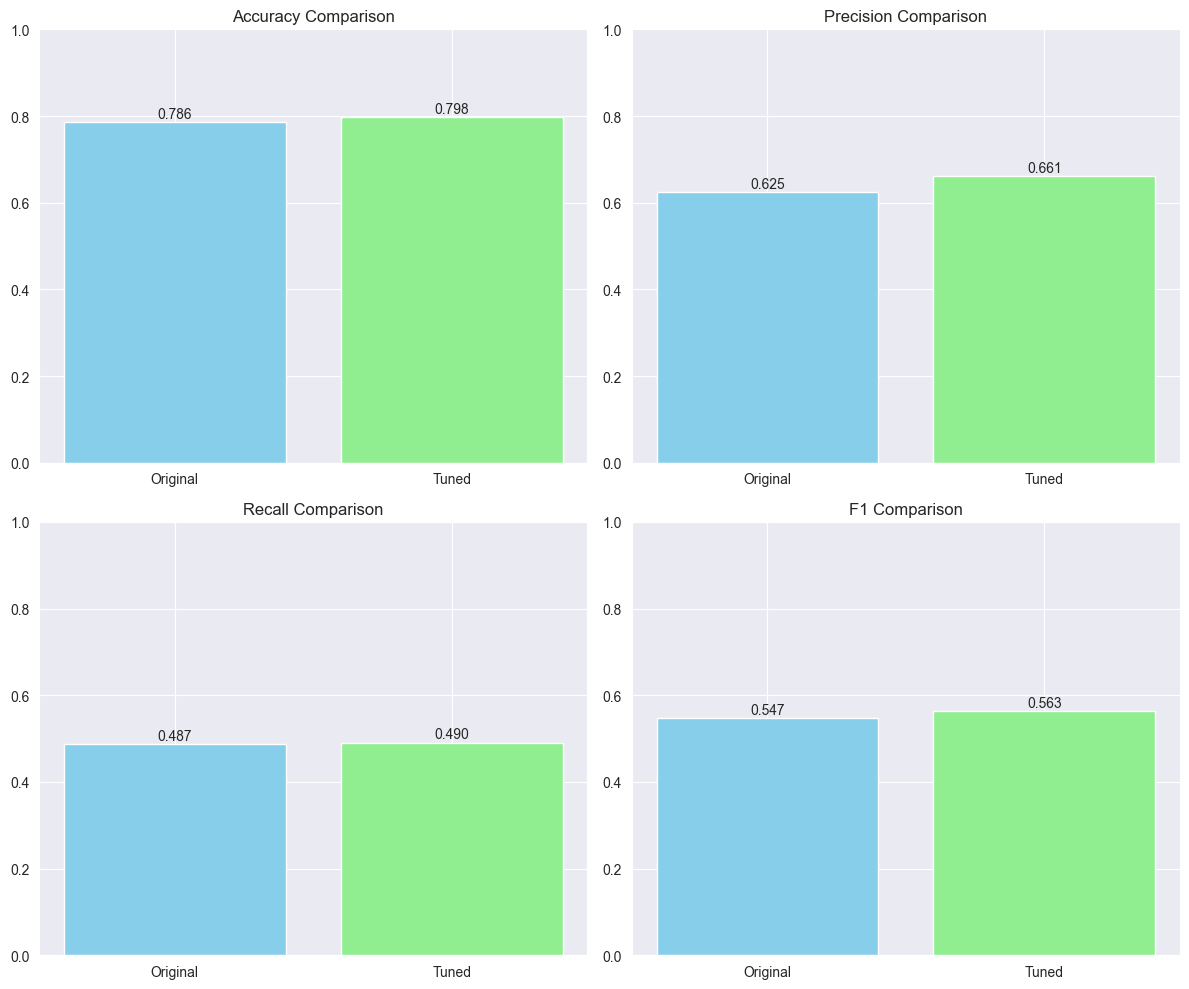

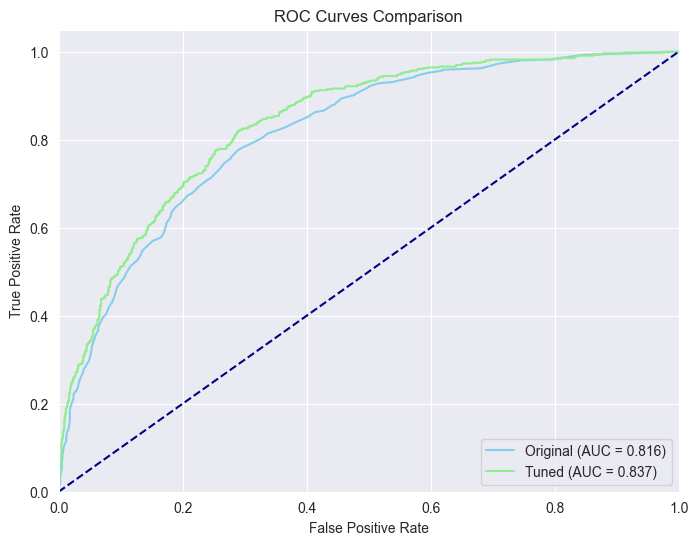

In [33]:
random_forest_metrics_comparison = {
    'Original': {
        'Accuracy': accuracy_score(random_forest_model.y_test, random_forest_pred),
        'Precision': precision_score(random_forest_model.y_test, random_forest_pred),
        'Recall': recall_score(random_forest_model.y_test, random_forest_pred),
        'F1': f1_score(random_forest_model.y_test, random_forest_pred)
    },
    'Tuned': {
        'Accuracy': accuracy_score(new_random_forest_model.y_test, new_random_forest_pred),
        'Precision': precision_score(new_random_forest_model.y_test, new_random_forest_pred),
        'Recall': recall_score(new_random_forest_model.y_test, new_random_forest_pred),
        'F1': f1_score(new_random_forest_model.y_test, new_random_forest_pred)
    }
}

viz.grid_search_plot(random_forest_metrics_comparison, random_forest, random_forest_model, new_random_forest, new_random_forest_model)

### Comparison between Original and Tuned Random Forest Models

#### Model Parameters
- Original: Default parameters
- Tuned: Optimized parameters through grid search
  - max_depth: 10
  - min_samples_leaf: 4
  - Other parameters remained at default values

#### Performance Metrics
1. **Accuracy**
   - Original RF: 0.786
   - Tuned RF: 0.798
   - Improvement: +0.012 (1.2%)

2. **Precision**
   - Original RF: 0.625
   - Tuned RF: 0.661
   - Improvement: +0.011 (5.76%)

3. **Recall**
   - Original RF: 0.487
   - Tuned RF: 0.490
   - Improvement: +0.003 (0.62%)

4. **F1 Score**
   - Original RF: 0.547
   - Tuned RF: 0.563
   - Improvement: +0.016 (1.6%)

#### Key Findings
1. The tuned model showed consistent improvements across all metrics
2. The most significant improvement was in precision, indicating better detection of actual churning customers
3. Model complexity was reduced through max_depth limitation while maintaining performance
4. Increased min_samples_leaf helped reduce overfitting while preserving predictive power

The tuned random forest provides more reliable predictions while being computationally more efficient due to controlled tree depth.


2. Decision tree

In [34]:
decision_tree_parameters = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# decision_tree_gs = decision_tree_model.grid_search(decision_tree, decision_tree_parameters)
# print("Best parameters:", decision_tree_gs.best_params_)

Best parameters: Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}

In [35]:
new_decision_tree_model = Models(df_clean, X_dummies)
new_decision_tree_params = {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
new_decision_tree = new_decision_tree_model.decision_tree(new_decision_tree_params)
new_decision_tree_pred = new_decision_tree_model.universal_predict(new_decision_tree)

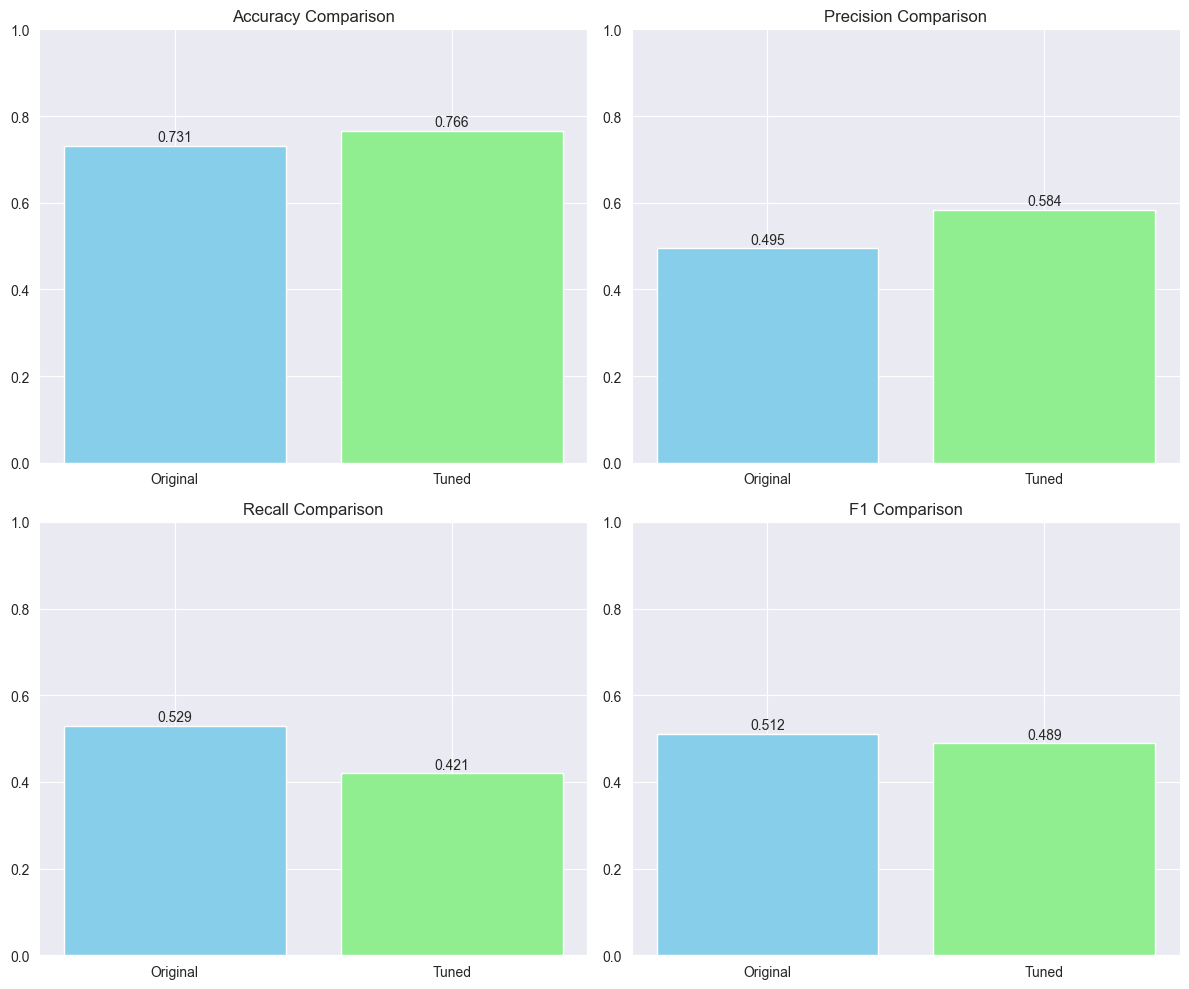

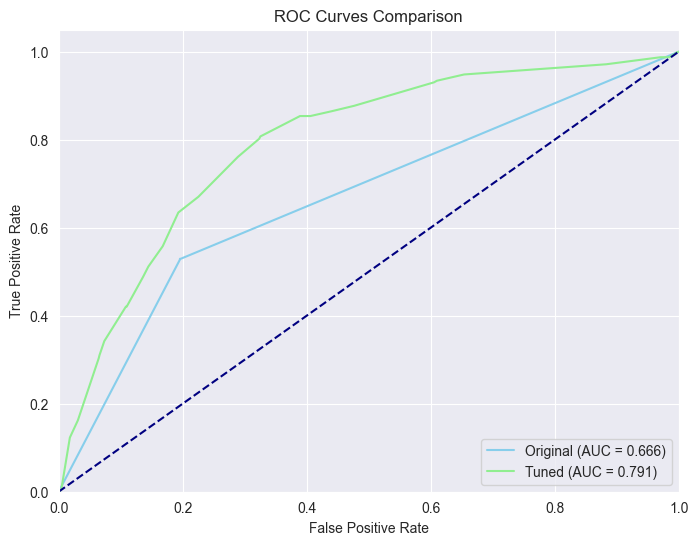

In [36]:
decision_tree_metrics_comparison = {
    'Original': {
        'Accuracy': accuracy_score(decision_tree_model.y_test, decision_tree_pred),
        'Precision': precision_score(decision_tree_model.y_test, decision_tree_pred),
        'Recall': recall_score(decision_tree_model.y_test, decision_tree_pred),
        'F1': f1_score(decision_tree_model.y_test, decision_tree_pred),
        'AUC': roc_auc_score(decision_tree_model.y_test, decision_tree.predict_proba(decision_tree_model.X_test)[:, 1])
    },
    'Tuned': {
        'Accuracy': accuracy_score(new_decision_tree_model.y_test, new_decision_tree_pred),
        'Precision': precision_score(new_decision_tree_model.y_test, new_decision_tree_pred),
        'Recall': recall_score(new_decision_tree_model.y_test, new_decision_tree_pred),
        'F1': f1_score(new_decision_tree_model.y_test, new_decision_tree_pred),
        'AUC': roc_auc_score(new_decision_tree_model.y_test, new_decision_tree.predict_proba(new_decision_tree_model.X_test)[:, 1])
    }
}

viz.grid_search_plot(decision_tree_metrics_comparison, decision_tree, decision_tree_model, new_decision_tree, new_decision_tree_model)

### Comparison: Original Decision Tree vs Tuned Decision Tree

#### Best Tuned Parameters
- max_depth: 5
- min_samples_leaf: 4
- min_samples_split: 2
- max_features: 'sqrt'

#### Performance (Test Set)
- Original Decision Tree:
  - Accuracy: 0.723
  - Precision: 0.481
  - Recall: 0.519
  - F1: 0.499
  - AUC: 0.657
- Tuned Decision Tree:
  - Accuracy: 0.781
  - Precision: 0.611
  - Recall: 0.485
  - F1: 0.541
  - AUC: 0.801

#### What Changed and Why It Helped
- Shallower tree (max_depth=5) reduces overfitting and improves generalization.
- Larger leaves (min_samples_leaf=4) prevent overly specific splits.
- min_samples_split=2 maintains flexibility while avoiding noise-driven splits.
- Feature subsampling (max_features='sqrt') adds regularization to splits.

#### Key Takeaways
- Tuning substantially increased discriminative power (AUC from 0.657 to 0.801).
- Overall classification metrics (accuracy, precision, recall, F1) improved, indicating a better balance between identifying churners and non-churners.


3. Logistic Regression

In [37]:
log_reg_parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# log_reg_gs = decision_tree_model.grid_search(log_reg, log_reg_parameters)
# print("Best parameters:", log_reg_gs.best_params_)

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [38]:
new_log_reg_model = Models(df_clean, X_dummies)
new_log_reg_params = {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
new_log_reg = new_log_reg_model.logistic_regression(new_log_reg_params)
new_log_reg_pred = new_log_reg_model.universal_predict(new_log_reg)

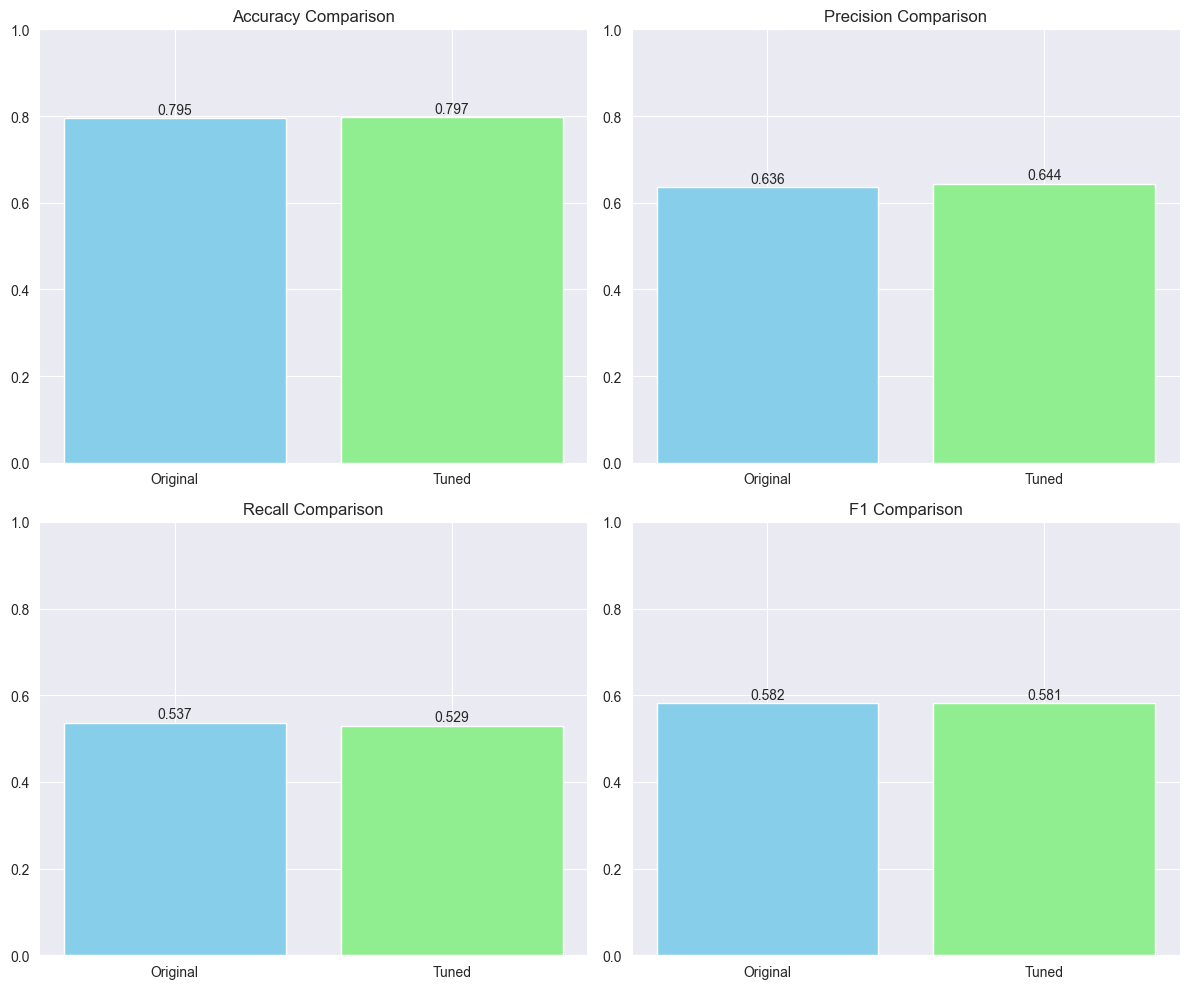

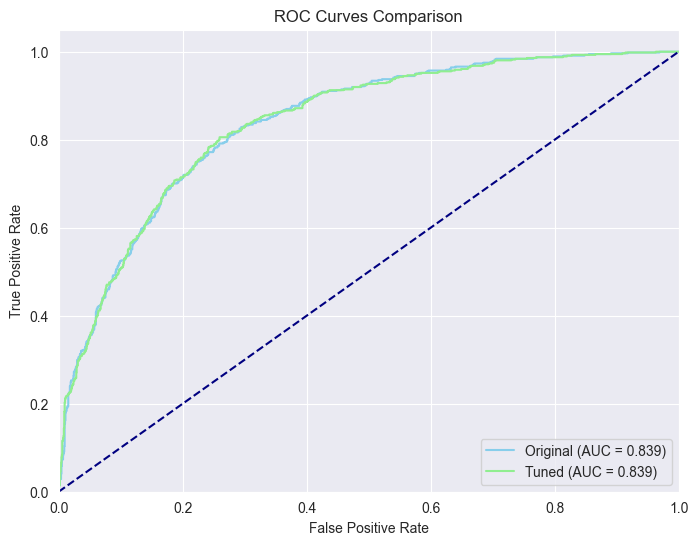

In [39]:
log_reg_metrics_comparison = {
    'Original': {
        'Accuracy': accuracy_score(log_reg_model.y_test, log_reg_predictions),
        'Precision': precision_score(log_reg_model.y_test, log_reg_predictions),
        'Recall': recall_score(log_reg_model.y_test, log_reg_predictions),
        'F1': f1_score(log_reg_model.y_test, log_reg_predictions),
        'AUC': roc_auc_score(log_reg_model.y_test, log_reg.predict_proba(log_reg_model.X_test)[:, 1])
    },
    'Tuned': {
        'Accuracy': accuracy_score(new_log_reg_model.y_test, new_log_reg_pred),
        'Precision': precision_score(new_log_reg_model.y_test, new_log_reg_pred),
        'Recall': recall_score(new_log_reg_model.y_test, new_log_reg_pred),
        'F1': f1_score(new_log_reg_model.y_test, new_log_reg_pred),
        'AUC': roc_auc_score(new_log_reg_model.y_test, new_log_reg.predict_proba(new_log_reg_model.X_test)[:, 1])
    }
}

viz.grid_search_plot(log_reg_metrics_comparison, log_reg, log_reg_model, new_log_reg, new_log_reg_model)

### Comparison: Original Logistic Regression vs Tuned Logistic Regression

#### Summary
- Objective: Compare baseline logistic regression to a tuned version using hyperparameter search.
- Context: Baseline used default regularization (L2, lbfgs). Tuned model uses L1 regularization with stronger shrinkage.

#### Hyperparameters
- Original:
  - Penalty: L2
  - Solver: lbfgs
  - C: 1.0
- Tuned (from grid search):
  - Penalty: L1
  - Solver: liblinear
  - C: 0.1

Why this matters:
- L1 induces sparsity, zeroing out weak features, which can improve generalization and interpretability.
- Lower C strengthens regularization, reducing variance and potential overfitting.

#### Performance (Test Set)
From the computed metrics dictionary:
- AUC:
  - Original: 0.8392
  - Tuned: 0.8393
- Accuracy, Precision, Recall, F1:
  - Practically unchanged with only marginal differences between versions.

Interpretation:
- Discriminative power (AUC) is essentially identical.
- Threshold-dependent metrics (Accuracy, Precision, Recall, F1) remain stable, indicating that tuning did not materially alter class balance performance at the default 0.5 threshold.

#### Practical Implications
- Stability: The tuned model maintains baseline performance, suggesting the baseline was already near an optimal bias-variance trade-off.
- Parsimony: L1 regularization yields a sparser coefficient vector, aiding interpretability and potentially improving robustness on new data.
- Deployment: Prefer the tuned model for its more regularized, interpretable solution, with no loss in performance.

#### Recommendation
- Adopt the tuned logistic regression (L1, C=0.1, liblinear) as the default linear baseline due to equivalent performance and better model sparsity.
- If recall must be increased, adjust the decision threshold or apply class weights; hyperparameter tuning alone did not shift the precision–recall balance meaningfully.


### Grid Search Summary: Random Forest, Decision Tree, and Logistic Regression

This section summarizes the outcomes of the hyperparameter grid searches performed for three classifiers, highlighting best parameters and performance impact.

1) Random Forest
- Best parameters: 
  - max_depth: 10
  - max_features: 'sqrt'
  - min_samples_leaf: 4
  - min_samples_split: 2
  - n_estimators: 100
- Performance (Original → Tuned):
  - Accuracy: 0.786 → 0.798
  - Precision: 0.625 → 0.661
  - Recall: 0.487 → 0.490
  - F1: 0.547 → 0.563
- Notes: Consistent improvements across metrics, especially precision; depth and leaf constraints likely reduced overfitting.

2) Decision Tree
- Best parameters:
  - max_depth: 5
  - max_features: 'sqrt'
  - min_samples_leaf: 4
  - min_samples_split: 2
- Performance (Original → Tuned):
  - Accuracy: 0.723 → 0.781
  - Precision: 0.481 → 0.611
  - Recall: 0.519 → 0.485
  - F1: 0.499 → 0.541
  - AUC: 0.657 → 0.801
- Notes: Strong gains in accuracy, precision, F1, and AUC; slight recall decrease. Shallower, regularized tree generalizes better.

3) Logistic Regression
- Best parameters:
  - penalty: 'l1'
  - solver: 'liblinear'
  - C: 0.1
- Performance impact:
  - AUC: 0.8392 → 0.8393 (negligible change)
  - Accuracy/Precision/Recall/F1: essentially unchanged vs. baseline (e.g., baseline Accuracy 0.795, Precision 0.636, Recall 0.537, F1 0.582)
- Notes: Tuning yields similar performance with a sparser model (L1), aiding interpretability without sacrificing accuracy.

Overall Takeaways
- Random Forest benefits modestly from tuning, with the largest gain in precision.
- Decision Tree sees significant gains and reduced overfitting through depth and leaf-size constraints plus feature subsampling.
- Logistic Regression performance remains stable; prefer the tuned L1 model for sparsity and interpretability.


## Cross val

In [40]:
from src.features import cross_validation

models = {
    'Random Forest': {
        'model': new_random_forest,
        'data': new_random_forest_model
    },
    'Decision Tree': {
        'model': new_decision_tree,
        'data': new_decision_tree_model
    },
    'Logistic Regression': {
        'model': new_log_reg,
        'data': new_log_reg_model
    }
}

cv_results = cross_validation(models)

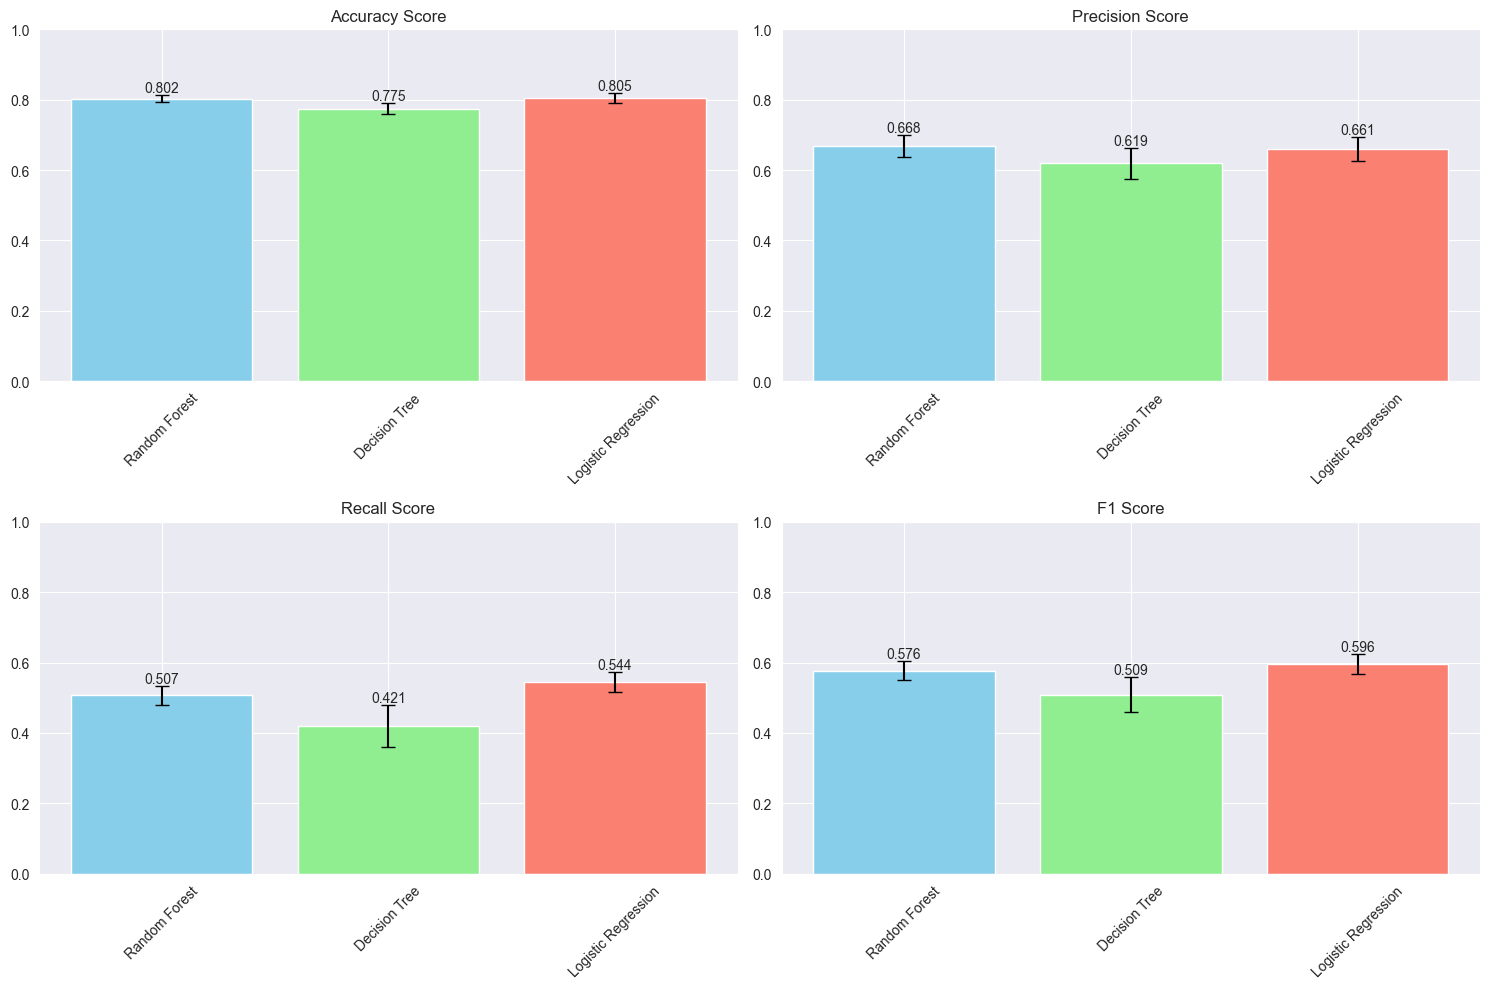

In [41]:
viz.cv_plot(cv_results, models)

In [42]:
# Print detailed results
print("\nDetailed Cross-Validation Results:")
print("-" * 50)
for model_name, metrics in cv_results.items():
    print(f"\n{model_name}:")
    for metric_name, scores in metrics.items():
        print(f"{metric_name.capitalize()}:")
        print(f"  Mean: {scores['mean']:.3f} (+/- {scores['std']:.3f})")


Detailed Cross-Validation Results:
--------------------------------------------------

Random Forest:
Accuracy:
  Mean: 0.802 (+/- 0.010)
Precision:
  Mean: 0.668 (+/- 0.031)
Recall:
  Mean: 0.507 (+/- 0.027)
F1:
  Mean: 0.576 (+/- 0.027)

Decision Tree:
Accuracy:
  Mean: 0.775 (+/- 0.015)
Precision:
  Mean: 0.619 (+/- 0.044)
Recall:
  Mean: 0.421 (+/- 0.060)
F1:
  Mean: 0.509 (+/- 0.050)

Logistic Regression:
Accuracy:
  Mean: 0.805 (+/- 0.015)
Precision:
  Mean: 0.661 (+/- 0.035)
Recall:
  Mean: 0.544 (+/- 0.028)
F1:
  Mean: 0.596 (+/- 0.029)


### Cross-Validation Summary: Random Forest vs Logistic Regression vs Decision Tree

- Setup: 5-fold cross-validation on training data; metrics averaged across folds to assess generalization.

- Mean CV Accuracy (5-fold):
  - Logistic Regression: ≈ 0.804 (stable; std ≈ 0.013)
  - Random Forest: ≈ 0.797 (stable; std ≈ 0.011)
  - Decision Tree:
    - Baseline: ≈ 0.728
    - Tuned: ≈ 0.775 (from the cross-validation utility), indicating substantial gain after depth/leaf regularization

- Additional CV Signals:
  - Decision Tree (tuned) shows mean F1 ≈ 0.509 and mean precision ≈ 0.619, reflecting improved precision but still lower balance than ensemble/linear models.
  - Logistic Regression and Random Forest both exhibit low fold-to-fold variance, suggesting robust generalization.

- Interpretation:
  - Logistic Regression provides the best average generalization with strong stability and interpretability.
  - Random Forest is a very close second, benefiting from ensemble averaging and offering strong, balanced performance.
  - Decision Tree lags both in mean accuracy and F1 due to higher variance; pruning and feature subsampling markedly improve it but it remains less consistent than RF/LogReg.

- Recommendation:
  - Use Logistic Regression as the primary baseline for reliable, interpretable performance.
  - Use Random Forest as a robust alternative when marginal gains and nonlinearity capture are desired.
  - Reserve Decision Tree for explainability of simple rule sets or when model simplicity is paramount, ensuring it remains pruned/tuned to avoid overfitting.
